## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['25 hPa'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['25 hPa'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['25 hPa'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['25 hPa'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['25 hPa'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['25 hPa'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['25 hPa'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['25 hPa'] - data_df['25 hPa'].shift(lag)) / data_df['25 hPa'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['25 hPa'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['25 hPa'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['25 hPa'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['25 hPa'] - data_df['25 hPa'].mean()) / data_df['25 hPa'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['25 hPa'].median()
    mad = np.median(np.abs(data_df['25 hPa'] - median))
    data_df['mad_z_score'] = (data_df['25 hPa'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['25 hPa'] / data_df['25 hPa'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-10,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-10,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-10,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-10,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-10,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-10,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-10,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-10,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-01-11,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', 'ema_3', '20 hPa',
       'rolling_max_3', 'moving_average_3', 'rolling_min_2', 'z_score',
       'mad_z_score', 'interaction_ma_ema_2', 'moving_average_2',
       'moving_median_2', 'ema_12', 'rolling_min_3', 'lag_1', 'lag_2',
       'interaction_ma_ema_3', 'rolling_min_12'],
      dtype='object')


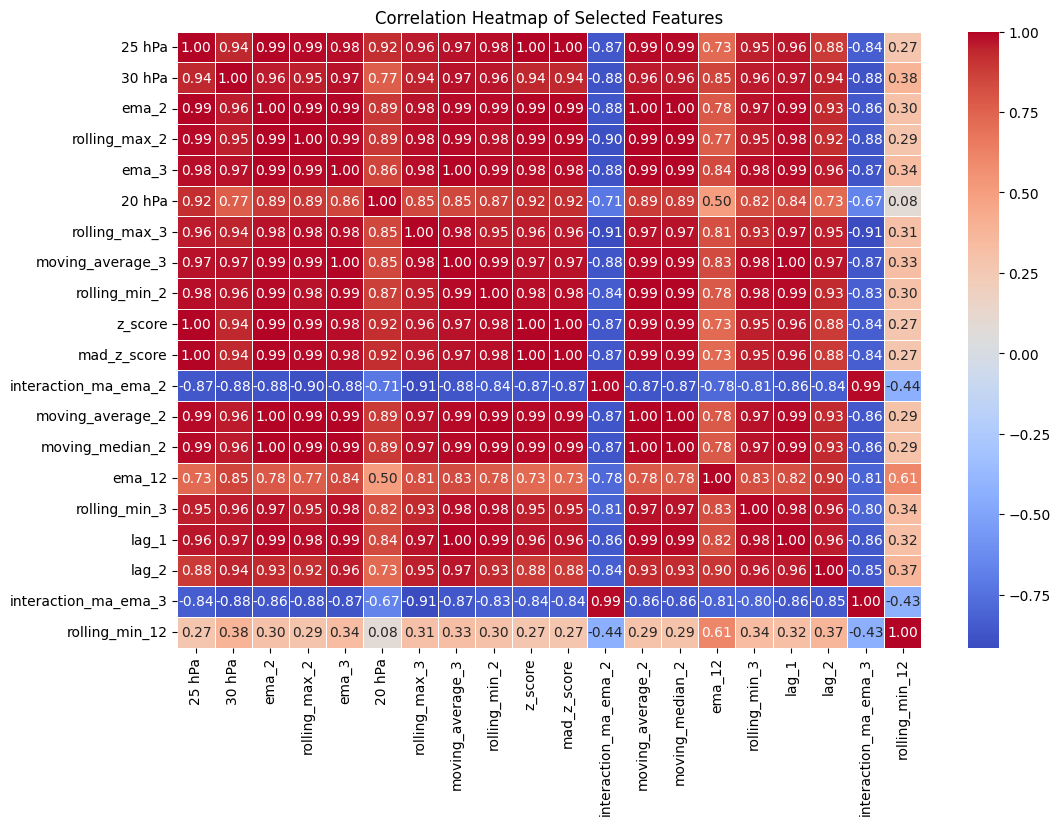

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.2, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(260, 28, 20) (260,)

Testing set shapes:
(65, 28, 20) (65,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 1.1005 - mae: 0.9337 - r_squared: -65.6160
Epoch 1: val_loss improved from inf to 1.05666, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 1.1702 - mae: 0.9828 - r_squared: -67.7334 - val_loss: 1.0567 - val_mae: 0.9759 - val_r_squared: -61.3602
Epoch 2/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.9204 - mae: 0.8845 - r_squared: -73.8664
Epoch 2: val_loss improved from 1.05666 to 0.82911, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.8255 - mae: 0.8337 - r_squared: -67.8206 - val_loss: 0.8291 - val_mae: 0.8492 - val_r_squared: -63.8384
Epoch 3/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6222 - mae: 0.7190 - r_squared: -76.4516
Epoch 3: val_loss improved from 0.82911 to 0.61957, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5895 - mae: 0.6923 - r_squared: -71.5646 - val_loss: 0.6196 - val_mae: 0.7121 - val_r_squared: -67.2065
Epoch 4/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4995 - mae: 0.6147 - r_squared: -83.8313
Epoch 4: val_loss improved from 0.61957 to 0.37616, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4458 - mae: 0.5819 - r_squared: -79.4339 - val_loss: 0.3762 - val_mae: 0.5081 - val_r_squared: -78.5504
Epoch 5/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3260 - mae: 0.4587 - r_squared: -103.1438
Epoch 5: val_loss improved from 0.37616 to 0.19498, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2954 - mae: 0.4287 - r_squared: -98.3924 - val_loss: 0.1950 - val_mae: 0.3166 - val_r_squared: -96.3287
Epoch 6/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2596 - mae: 0.3896 - r_squared: -123.7611
Epoch 6: val_loss improved from 0.19498 to 0.16016, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2156 - mae: 0.3550 - r_squared: -112.3564 - val_loss: 0.1602 - val_mae: 0.2880 - val_r_squared: -98.3793
Epoch 7/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2315 - mae: 0.3780 - r_squared: -113.1691
Epoch 7: val_loss improved from 0.16016 to 0.14556, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1989 - mae: 0.3521 - r_squared: -106.5612 - val_loss: 0.1456 - val_mae: 0.2725 - val_r_squared: -94.0150
Epoch 8/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1563 - mae: 0.2931 - r_squared: -115.2279
Epoch 8: val_loss did not improve from 0.14556
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1552 - mae: 0.2981 - r_squared: -104.6677 - val_loss: 0.1680 - val_mae: 0.2828 - val_r_squared: -95.8483
Epoch 9/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1019 - mae: 0.2449 - r_squared: -119.3553
Epoch 9: val_loss did not improve from 0.14556
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1328 - mae: 0.2678 - r_squared: -109.5314 - val_loss: 0.1623 - val_mae: 0.2752 - val_r_squared: -94.4728
Epoch 10/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1512 - mae: 0.2819 - r_squared: -119.6406
Epoch 10: val_loss improved from 0.14556 to 0.13412, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.1328 - mae: 0.2627 - r_squared: -107.8515 - val_loss: 0.1341 - val_mae: 0.2521 - val_r_squared: -94.2746
Epoch 11/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1359 - mae: 0.2585 - r_squared: -113.3638
Epoch 11: val_loss improved from 0.13412 to 0.12336, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1292 - mae: 0.2555 - r_squared: -106.7285 - val_loss: 0.1234 - val_mae: 0.2360 - val_r_squared: -98.7491
Epoch 12/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0771 - mae: 0.2084 - r_squared: -130.6928
Epoch 12: val_loss improved from 0.12336 to 0.11353, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0955 - mae: 0.2255 - r_squared: -114.3671 - val_loss: 0.1135 - val_mae: 0.2283 - val_r_squared: -98.1095
Epoch 13/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0553 - mae: 0.1892 - r_squared: -121.2283
Epoch 13: val_loss improved from 0.11353 to 0.10892, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0983 - mae: 0.2306 - r_squared: -111.0092 - val_loss: 0.1089 - val_mae: 0.2358 - val_r_squared: -98.5897
Epoch 14/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1221 - mae: 0.2738 - r_squared: -117.7018
Epoch 14: val_loss improved from 0.10892 to 0.09422, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1103 - mae: 0.2517 - r_squared: -109.4586 - val_loss: 0.0942 - val_mae: 0.2051 - val_r_squared: -98.8662
Epoch 15/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1213 - mae: 0.2381 - r_squared: -125.2091
Epoch 15: val_loss did not improve from 0.09422
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1064 - mae: 0.2219 - r_squared: -113.6824 - val_loss: 0.1071 - val_mae: 0.2092 - val_r_squared: -100.7240
Epoch 16/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0860 - mae: 0.1977 - r_squared: -124.7961
Epoch 16: val_loss improved from 0.09422 to 0.09140, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0963 - mae: 0.1997 - r_squared: -115.1049 - val_loss: 0.0914 - val_mae: 0.2005 - val_r_squared: -95.9110
Epoch 17/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1117 - mae: 0.2306 - r_squared: -116.7468
Epoch 17: val_loss improved from 0.09140 to 0.08717, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1011 - mae: 0.2199 - r_squared: -109.0445 - val_loss: 0.0872 - val_mae: 0.2102 - val_r_squared: -95.9528
Epoch 18/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1152 - mae: 0.2139 - r_squared: -118.7144
Epoch 18: val_loss improved from 0.08717 to 0.08507, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0925 - mae: 0.2076 - r_squared: -109.6390 - val_loss: 0.0851 - val_mae: 0.1992 - val_r_squared: -100.3590
Epoch 19/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0993 - mae: 0.2017 - r_squared: -121.4115
Epoch 19: val_loss did not improve from 0.08507
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0881 - mae: 0.1926 - r_squared: -114.9075 - val_loss: 0.0859 - val_mae: 0.1985 - val_r_squared: -98.0257
Epoch 20/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0766 - mae: 0.1998 - r_squared: -117.0787
Epoch 20: val_loss did not improve from 0.08507
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0738 - mae: 0.1892 - r_squared: -110.5096 - val_loss: 0.0905 - val_mae: 0.2136 - val_r_squared: -96.4578
Epoch 21/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0804 - mae: 0.2081 - r_squared: -112.2949
Epoch 21: val_loss improved from 0.08507 to 0.07539, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0807 - mae: 0.2077 - r_squared: -109.1164 - val_loss: 0.0754 - val_mae: 0.1999 - val_r_squared: -97.3481
Epoch 22/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0543 - mae: 0.1682 - r_squared: -118.7452
Epoch 22: val_loss improved from 0.07539 to 0.07399, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0711 - mae: 0.1861 - r_squared: -111.1743 - val_loss: 0.0740 - val_mae: 0.1843 - val_r_squared: -99.0830
Epoch 23/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0726 - mae: 0.1797 - r_squared: -126.5286
Epoch 23: val_loss did not improve from 0.07399
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0741 - mae: 0.1838 - r_squared: -112.7980 - val_loss: 0.0879 - val_mae: 0.2068 - val_r_squared: -97.2467
Epoch 24/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0678 - mae: 0.1976 - r_squared: -118.2848
Epoch 24: val_loss improved from 0.07399 to 0.06567, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0754 - mae: 0.1929 - r_squared: -111.6037 - val_loss: 0.0657 - val_mae: 0.1737 - val_r_squared: -98.7975
Epoch 25/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0339 - mae: 0.1470 - r_squared: -119.7322
Epoch 25: val_loss improved from 0.06567 to 0.06459, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0657 - mae: 0.1702 - r_squared: -112.3022 - val_loss: 0.0646 - val_mae: 0.1815 - val_r_squared: -101.8319
Epoch 26/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0676 - mae: 0.1803 - r_squared: -123.1152
Epoch 26: val_loss did not improve from 0.06459
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0686 - mae: 0.1826 - r_squared: -115.6710 - val_loss: 0.0780 - val_mae: 0.1997 - val_r_squared: -100.5200
Epoch 27/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0786 - mae: 0.1909 - r_squared: -120.8282
Epoch 27: val_loss improved from 0.06459 to 0.05770, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0712 - mae: 0.1855 - r_squared: -110.8587 - val_loss: 0.0577 - val_mae: 0.1771 - val_r_squared: -96.7433
Epoch 28/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0595 - mae: 0.1691 - r_squared: -117.2843
Epoch 28: val_loss did not improve from 0.05770
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0664 - mae: 0.1772 - r_squared: -109.6249 - val_loss: 0.0700 - val_mae: 0.1762 - val_r_squared: -104.3846
Epoch 29/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0516 - mae: 0.1605 - r_squared: -129.1292
Epoch 29: val_loss improved from 0.05770 to 0.05528, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0630 - mae: 0.1665 - r_squared: -118.2024 - val_loss: 0.0553 - val_mae: 0.1720 - val_r_squared: -98.4703
Epoch 30/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0368 - mae: 0.1448 - r_squared: -119.0448
Epoch 30: val_loss did not improve from 0.05528
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0572 - mae: 0.1665 - r_squared: -109.9586 - val_loss: 0.0555 - val_mae: 0.1705 - val_r_squared: -100.1233
Epoch 31/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0561 - mae: 0.1604 - r_squared: -118.2689
Epoch 31: val_loss improved from 0.05528 to 0.05050, saving model to best_model_lstm.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0605 - mae: 0.1618 - r_squared: -113.6701 - val_loss: 0.0505 - val_mae: 0.1661 - val_r_squared: -100.9904
Epoch 32/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0896 - mae: 0.1898 - r_squared: -123.1142
Epoch 32: val_loss did not improve from 0.05050
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0714 - mae: 0.1800 - r_squared: -111.2975 - val_loss: 0.0595 - val_mae: 0.1867 - val_r_squared: -101.6584
Epoch 33/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0567 - mae: 0.1587 - r_squared: -122.8958
Epoch 33: val_loss did not improve from 0.05050
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0607 - mae: 0.1635 - r_squared: -114.9651 - val_loss: 0.0509 - val_mae: 0.1647 - val_r_squared: -100.7683
Epoch 34/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0463 - mae: 0.1504 - r_squared: -118.0007
Epoch 34: val_loss did not improve from 0.05050
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0535 - mae: 0.1529 - r_squared: -112.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0661 - mae: 0.1836 - r_squared: -107.1449 - val_loss: 0.0426 - val_mae: 0.1479 - val_r_squared: -101.2925
Epoch 39/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0740 - mae: 0.1664 - r_squared: -123.7611
Epoch 39: val_loss did not improve from 0.04255
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0658 - mae: 0.1611 - r_squared: -117.1552 - val_loss: 0.0564 - val_mae: 0.1673 - val_r_squared: -103.6164
Epoch 40/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0475 - mae: 0.1537 - r_squared: -123.3665
Epoch 40: val_loss did not improve from 0.04255
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0542 - mae: 0.1611 - r_squared: -113.1139 - val_loss: 0.0861 - val_mae: 0.2160 - val_r_squared: -97.1866
Epoch 41/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0832 - mae: 0.2273 - r_squared: -111.0268
Epoch 41: val_loss did not improve from 0.04255
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0698 - mae: 0.1948 - r_squared: -106.7

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.3133 - mae: 0.9953 - r_squared: -78.0560
Epoch 1: val_loss improved from inf to 0.61231, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1.2876 - mae: 0.9837 - r_squared: -75.5014 - val_loss: 0.6123 - val_mae: 0.6520 - val_r_squared: -69.4592
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.6366 - mae: 0.6670 - r_squared: -82.4163
Epoch 2: val_loss improved from 0.61231 to 0.57996, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.6293 - mae: 0.6621 - r_squared: -80.4462 - val_loss: 0.5800 - val_mae: 0.5322 - val_r_squared: -88.5867
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.5543 - mae: 0.5588 - r_squared: -103.2395 
Epoch 3: val_loss improved from 0.57996 to 0.41166, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 0.5504 - mae: 0.5573 - r_squared: -100.3711 - val_loss: 0.4117 - val_mae: 0.4989 - val_r_squared: -84.4259
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.4405 - mae: 0.5150 - r_squared: -105.3210
Epoch 4: val_loss improved from 0.41166 to 0.36238, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - loss: 0.4416 - mae: 0.5179 - r_squared: -101.9870 - val_loss: 0.3624 - val_mae: 0.5043 - val_r_squared: -78.8396
Epoch 5/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4479 - mae: 0.5376 - r_squared: -102.3334
Epoch 5: val_loss improved from 0.36238 to 0.35800, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - loss: 0.4351 - mae: 0.5343 - r_squared: -94.8219 - val_loss: 0.3580 - val_mae: 0.4996 - val_r_squared: -76.4634
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3610 - mae: 0.4882 - r_squared: -95.3520  
Epoch 6: val_loss improved from 0.35800 to 0.35222, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - loss: 0.3607 - mae: 0.4885 - r_squared: -92.3736 - val_loss: 0.3522 - val_mae: 0.4757 - val_r_squared: -78.5786
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.3453 - mae: 0.4649 - r_squared: -96.3216  
Epoch 7: val_loss improved from 0.35222 to 0.32246, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.3456 - mae: 0.4644 - r_squared: -93.3850 - val_loss: 0.3225 - val_mae: 0.4194 - val_r_squared: -85.2013
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.3494 - mae: 0.4546 - r_squared: -101.7311
Epoch 8: val_loss improved from 0.32246 to 0.30847, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 0.3393 - mae: 0.4482 - r_squared: -98.7997 - val_loss: 0.3085 - val_mae: 0.4114 - val_r_squared: -90.3477
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2916 - mae: 0.4166 - r_squared: -107.8378
Epoch 9: val_loss improved from 0.30847 to 0.27103, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - loss: 0.2904 - mae: 0.4161 - r_squared: -104.4100 - val_loss: 0.2710 - val_mae: 0.3895 - val_r_squared: -93.8514
Epoch 10/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2883 - mae: 0.4105 - r_squared: -113.6200
Epoch 10: val_loss improved from 0.27103 to 0.23577, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.2787 - mae: 0.4051 - r_squared: -105.8234 - val_loss: 0.2358 - val_mae: 0.3678 - val_r_squared: -90.8930
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2226 - mae: 0.3756 - r_squared: -108.6186
Epoch 11: val_loss improved from 0.23577 to 0.22158, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.2213 - mae: 0.3735 - r_squared: -105.1576 - val_loss: 0.2216 - val_mae: 0.3608 - val_r_squared: -88.7790
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2694 - mae: 0.3953 - r_squared: -105.9833 
Epoch 12: val_loss improved from 0.22158 to 0.20514, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - loss: 0.2653 - mae: 0.3916 - r_squared: -102.7183 - val_loss: 0.2051 - val_mae: 0.3453 - val_r_squared: -90.5959
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2278 - mae: 0.3755 - r_squared: -111.4025 
Epoch 13: val_loss improved from 0.20514 to 0.19407, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.2273 - mae: 0.3742 - r_squared: -107.9931 - val_loss: 0.1941 - val_mae: 0.3295 - val_r_squared: -94.8695
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2325 - mae: 0.3635 - r_squared: -118.2794
Epoch 14: val_loss did not improve from 0.19407
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.2323 - mae: 0.3649 - r_squared: -114.4201 - val_loss: 0.1953 - val_mae: 0.3271 - val_r_squared: -91.7693
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2053 - mae: 0.3418 - r_squared: -109.7739 
Epoch 15: val_loss did not improve from 0.19407
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.2050 - mae: 0.3407 - r_squared: -106.5043 - val_loss: 0.2072 - val_mae: 0.3357 - val_r_squared: -91.7392
Epoch 16/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2103 - mae: 0.3321 - r_squared: -112.9700
Epoch 16: val_loss did not improve from 0.19407
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.2069 - mae: 0.3285 - r_squared: -1

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.2013 - mae: 0.3312 - r_squared: -106.4000 - val_loss: 0.1802 - val_mae: 0.3192 - val_r_squared: -93.2179
Epoch 18/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1887 - mae: 0.3274 - r_squared: -109.0250 
Epoch 18: val_loss improved from 0.18023 to 0.16051, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 0.1887 - mae: 0.3269 - r_squared: -105.8275 - val_loss: 0.1605 - val_mae: 0.2966 - val_r_squared: -96.1247
Epoch 19/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1717 - mae: 0.3146 - r_squared: -117.5522
Epoch 19: val_loss improved from 0.16051 to 0.14782, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.1716 - mae: 0.3134 - r_squared: -114.0884 - val_loss: 0.1478 - val_mae: 0.2829 - val_r_squared: -95.3708
Epoch 20/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1749 - mae: 0.3070 - r_squared: -112.5905
Epoch 20: val_loss improved from 0.14782 to 0.13242, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step - loss: 0.1734 - mae: 0.3051 - r_squared: -109.3571 - val_loss: 0.1324 - val_mae: 0.2726 - val_r_squared: -95.1698
Epoch 21/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1393 - mae: 0.2839 - r_squared: -111.0405 
Epoch 21: val_loss improved from 0.13242 to 0.13143, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 0.1397 - mae: 0.2845 - r_squared: -107.8512 - val_loss: 0.1314 - val_mae: 0.2688 - val_r_squared: -96.1587
Epoch 22/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1365 - mae: 0.2750 - r_squared: -113.4438 
Epoch 22: val_loss improved from 0.13143 to 0.13084, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - loss: 0.1373 - mae: 0.2753 - r_squared: -110.3073 - val_loss: 0.1308 - val_mae: 0.2654 - val_r_squared: -96.2204
Epoch 23/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1569 - mae: 0.2867 - r_squared: -113.1481
Epoch 23: val_loss improved from 0.13084 to 0.12709, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - loss: 0.1579 - mae: 0.2869 - r_squared: -110.2097 - val_loss: 0.1271 - val_mae: 0.2723 - val_r_squared: -91.5672
Epoch 24/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1657 - mae: 0.2985 - r_squared: -109.0228
Epoch 24: val_loss did not improve from 0.12709
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.1635 - mae: 0.2981 - r_squared: -105.3977 - val_loss: 0.1289 - val_mae: 0.2812 - val_r_squared: -92.7889
Epoch 25/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1500 - mae: 0.2962 - r_squared: -106.7248 
Epoch 25: val_loss did not improve from 0.12709
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.1478 - mae: 0.2947 - r_squared: -103.9173 - val_loss: 0.1281 - val_mae: 0.2721 - val_r_squared: -101.7465
Epoch 26/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1270 - mae: 0.2753 - r_squared: -118.0382 
Epoch 26: val_loss improved from 0.12709 to 0.11966, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 0.1270 - mae: 0.2751 - r_squared: -114.4587 - val_loss: 0.1197 - val_mae: 0.2523 - val_r_squared: -97.4867
Epoch 27/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1439 - mae: 0.2883 - r_squared: -112.0923 
Epoch 27: val_loss improved from 0.11966 to 0.11436, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 0.1458 - mae: 0.2893 - r_squared: -109.1273 - val_loss: 0.1144 - val_mae: 0.2523 - val_r_squared: -95.4817
Epoch 28/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1350 - mae: 0.2833 - r_squared: -113.0561 
Epoch 28: val_loss did not improve from 0.11436
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.1368 - mae: 0.2846 - r_squared: -109.7359 - val_loss: 0.1323 - val_mae: 0.2911 - val_r_squared: -101.3895
Epoch 29/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1310 - mae: 0.2715 - r_squared: -113.2320
Epoch 29: val_loss did not improve from 0.11436
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.1302 - mae: 0.2706 - r_squared: -109.9830 - val_loss: 0.1297 - val_mae: 0.2830 - val_r_squared: -99.8371
Epoch 30/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1088 - mae: 0.2520 - r_squared: -113.2327 
Epoch 30: val_loss improved from 0.11436 to 0.11212, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - loss: 0.1100 - mae: 0.2532 - r_squared: -109.9646 - val_loss: 0.1121 - val_mae: 0.2628 - val_r_squared: -94.6494
Epoch 31/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1268 - mae: 0.2670 - r_squared: -112.3659
Epoch 31: val_loss improved from 0.11212 to 0.10458, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 0.1248 - mae: 0.2657 - r_squared: -108.8137 - val_loss: 0.1046 - val_mae: 0.2473 - val_r_squared: -92.9030
Epoch 32/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1209 - mae: 0.2663 - r_squared: -110.8575
Epoch 32: val_loss improved from 0.10458 to 0.10432, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - loss: 0.1211 - mae: 0.2677 - r_squared: -107.5061 - val_loss: 0.1043 - val_mae: 0.2375 - val_r_squared: -104.9623
Epoch 33/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1137 - mae: 0.2640 - r_squared: -119.9543 
Epoch 33: val_loss did not improve from 0.10432
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.1130 - mae: 0.2627 - r_squared: -116.8203 - val_loss: 0.1193 - val_mae: 0.2475 - val_r_squared: -109.5166
Epoch 34/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1115 - mae: 0.2610 - r_squared: -132.6098
Epoch 34: val_loss did not improve from 0.10432
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.1187 - mae: 0.2659 - r_squared: -121.5496 - val_loss: 0.1066 - val_mae: 0.2437 - val_r_squared: -96.3898
Epoch 35/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1026 - mae: 0.2394 - r_squared: -111.2672 
Epoch 35: val_loss did not improve from 0.10432
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.1035 - mae: 0.2406 - r_squared: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - loss: 0.1007 - mae: 0.2406 - r_squared: -111.7696 - val_loss: 0.0976 - val_mae: 0.2279 - val_r_squared: -101.2762
Epoch 37/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0863 - mae: 0.2206 - r_squared: -127.4492
Epoch 37: val_loss improved from 0.09763 to 0.08870, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 0.0932 - mae: 0.2279 - r_squared: -118.7939 - val_loss: 0.0887 - val_mae: 0.2133 - val_r_squared: -101.6863
Epoch 38/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1067 - mae: 0.2386 - r_squared: -116.6109
Epoch 38: val_loss improved from 0.08870 to 0.08286, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - loss: 0.1077 - mae: 0.2400 - r_squared: -113.0019 - val_loss: 0.0829 - val_mae: 0.2134 - val_r_squared: -96.6676
Epoch 39/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1033 - mae: 0.2519 - r_squared: -111.8801
Epoch 39: val_loss did not improve from 0.08286
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.1045 - mae: 0.2528 - r_squared: -108.4437 - val_loss: 0.0962 - val_mae: 0.2238 - val_r_squared: -105.6909
Epoch 40/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0952 - mae: 0.2423 - r_squared: -126.9706
Epoch 40: val_loss did not improve from 0.08286
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0940 - mae: 0.2410 - r_squared: -117.0893 - val_loss: 0.1143 - val_mae: 0.2511 - val_r_squared: -106.0304
Epoch 41/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0985 - mae: 0.2428 - r_squared: -119.0339
Epoch 41: val_loss did not improve from 0.08286
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0995 - mae: 0.2440 - r_squared: -1

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - loss: 0.0856 - mae: 0.2284 - r_squared: -116.2382 - val_loss: 0.0824 - val_mae: 0.2139 - val_r_squared: -100.9778
Epoch 49/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0865 - mae: 0.2284 - r_squared: -114.5345
Epoch 49: val_loss improved from 0.08245 to 0.07813, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - loss: 0.0880 - mae: 0.2305 - r_squared: -110.6498 - val_loss: 0.0781 - val_mae: 0.2125 - val_r_squared: -95.2584
Epoch 50/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0840 - mae: 0.2268 - r_squared: -116.1211
Epoch 50: val_loss did not improve from 0.07813
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0859 - mae: 0.2287 - r_squared: -107.3484 - val_loss: 0.0875 - val_mae: 0.2125 - val_r_squared: -100.7603
Epoch 51/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1122 - mae: 0.2440 - r_squared: -122.2270 
Epoch 51: val_loss did not improve from 0.07813
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.1063 - mae: 0.2379 - r_squared: -113.3182 - val_loss: 0.1053 - val_mae: 0.2326 - val_r_squared: -105.8570
Epoch 52/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0814 - mae: 0.2277 - r_squared: -121.9718
Epoch 52: val_loss did not improve from 0.07813
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0809 - mae: 0.2259 - r_squared: -

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - loss: 0.0418 - mae: 0.1527 - r_squared: -114.1552 - val_loss: 0.0704 - val_mae: 0.1909 - val_r_squared: -104.0334
Epoch 118/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0505 - mae: 0.1713 - r_squared: -117.2877
Epoch 118: val_loss improved from 0.07040 to 0.06835, saving model to best_model_transformer.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step - loss: 0.0503 - mae: 0.1713 - r_squared: -113.9337 - val_loss: 0.0683 - val_mae: 0.1936 - val_r_squared: -103.0776
Epoch 119/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0481 - mae: 0.1701 - r_squared: -120.2168 
Epoch 119: val_loss did not improve from 0.06835
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0484 - mae: 0.1707 - r_squared: -116.3487 - val_loss: 0.0832 - val_mae: 0.2127 - val_r_squared: -105.8415
Epoch 120/200
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0393 - mae: 0.1499 - r_squared: -127.9363
Epoch 120: val_loss did not improve from 0.06835
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0399 - mae: 0.1499 - r_squared: -118.2328 - val_loss: 0.0970 - val_mae: 0.2301 - val_r_squared: -107.5355
Epoch 121/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0415 - mae: 0.1587 - r_squared: -117.2637 
Epoch 121: val_loss did not improve from 0.06835
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0417 - mae: 0.1586 - r_s

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


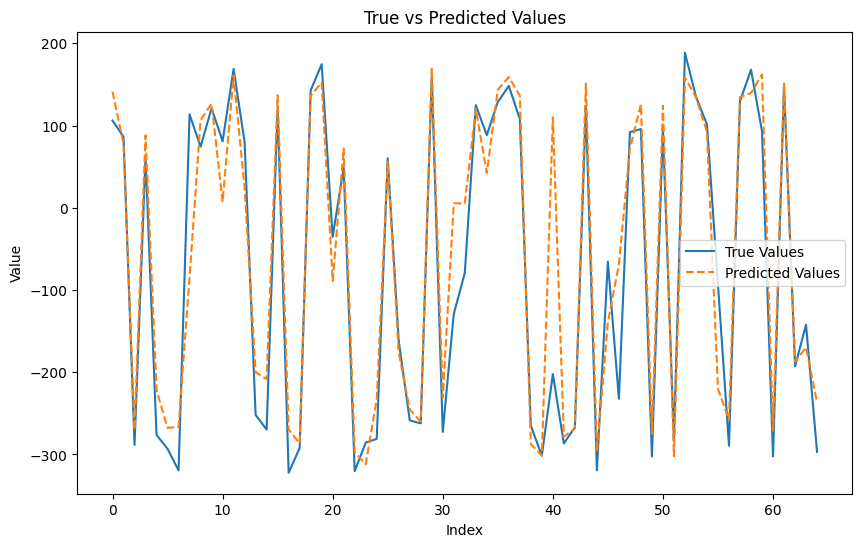

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


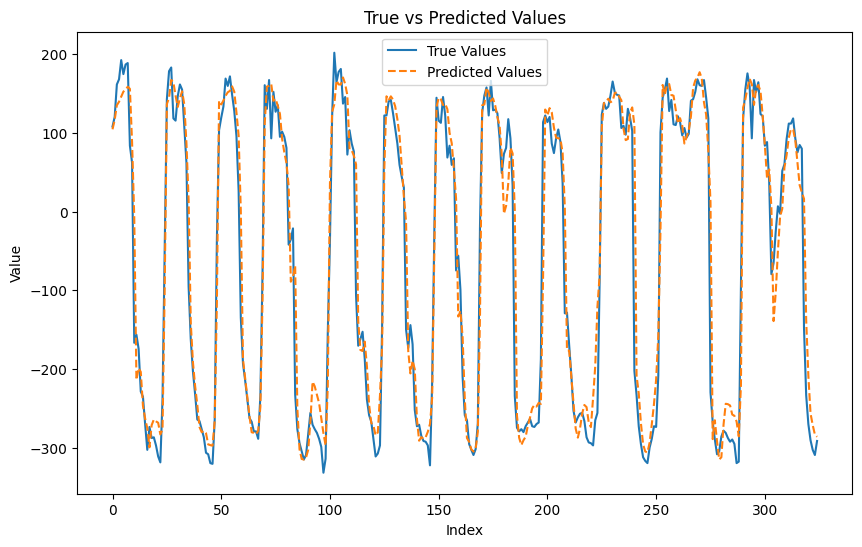

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


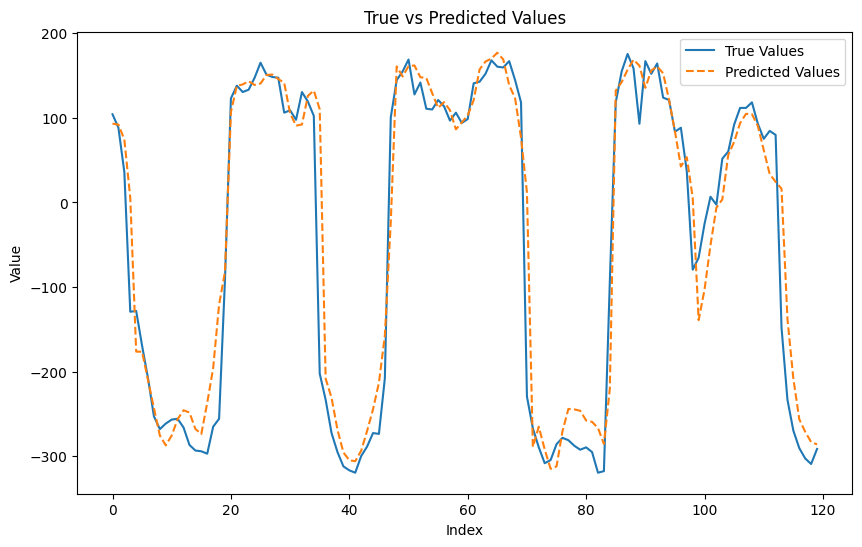

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


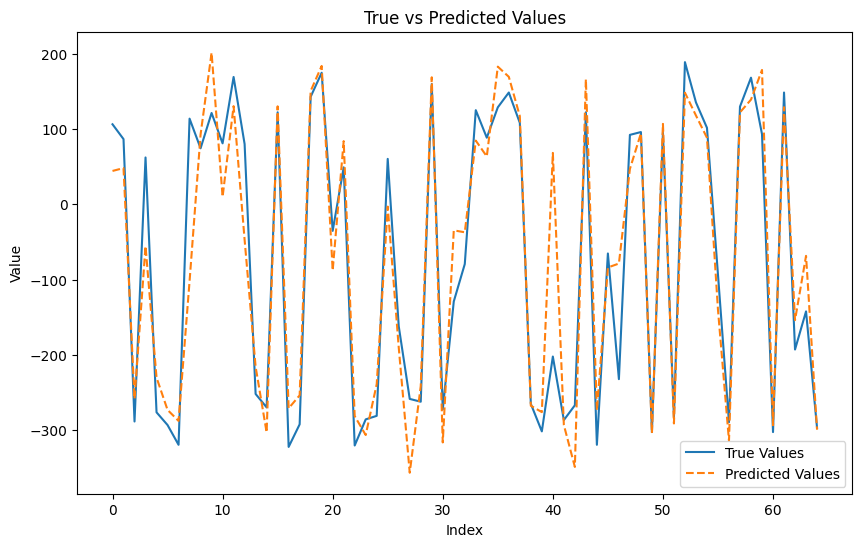

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


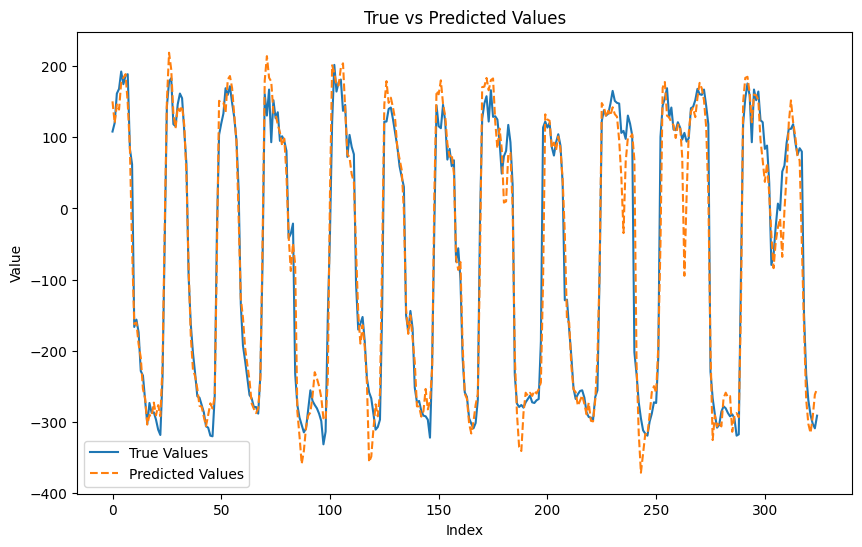

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


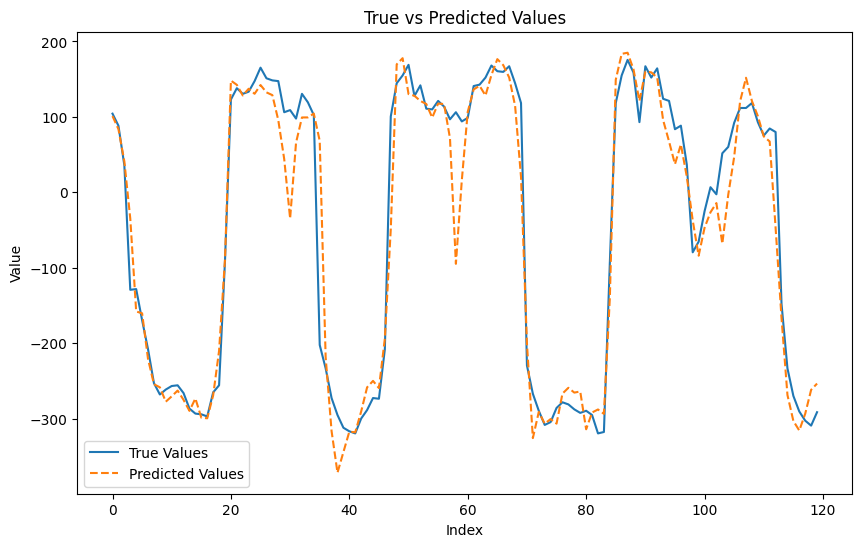

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


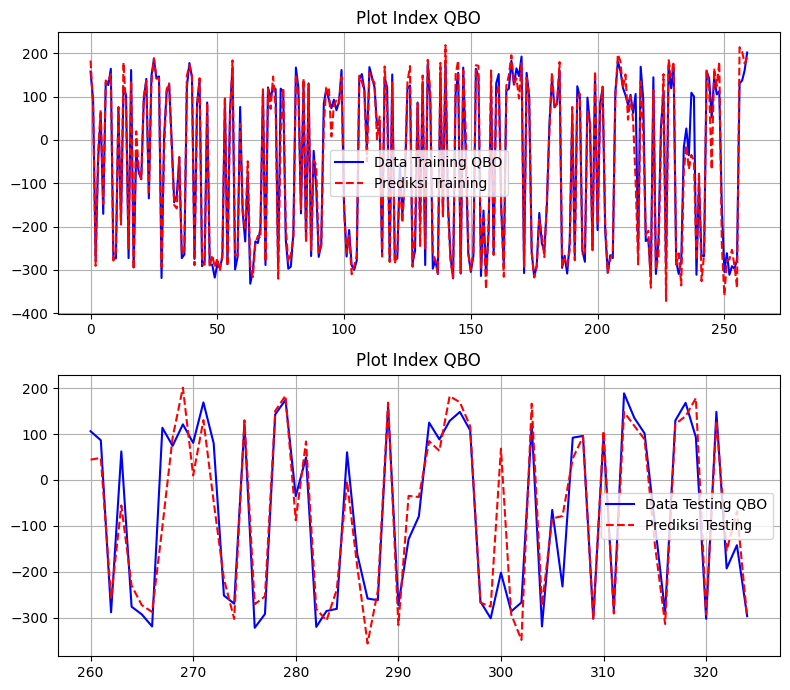

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.06935898408672603
RMSE:  0.26336093880210487
R-squared:  0.9307335070814512
MAE:  0.16653729630168987
Log Likelihood:  -199682.8849300462
MAPE:  170.9307908481574


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.04766750060892484
RMSE:  0.21832888175622767
R-squared:  0.952396064664896
MAE:  0.13906721210069486
Log Likelihood:  -202531.555655725
MAPE:  174.01361541321037


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.11638561814714933
RMSE:  0.3411533645549305
R-squared:  0.8842913189212012
MAE:  0.21042486134254532
Log Likelihood:  -7959.935311977525
MAPE:  219.49680099367174


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.1203765114776282
RMSE:  0.3469531834089842
R-squared:  0.8803236379401022
MAE:  0.24004206080214588
Log Likelihood:  -8009.813111614439
MAPE:  218.5539061053144


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  2468.322479782707
RMSE:  49.68221492428359
R-squared:  0.9307335057837476
MAE:  31.416738849639614
Log Likelihood:  -401401.0579879815
MAPE:  31.946910406320406


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  1696.3737813136615
RMSE:  41.18705842025698
R-squared:  0.9523960642604896
MAE:  26.234593538020295
Log Likelihood:  -275959.39448676154
MAPE:  25.999831853549132


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  3010.098046407607
RMSE:  54.86436043924696
R-squared:  0.917043207194434
MAE:  32.64175151241291
Log Likelihood:  -180716.15540844097
MAPE:  32.54883321887957


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  2364.426577730825
RMSE:  48.62536969248486
R-squared:  0.9348375891121292
MAE:  28.998112637957426
Log Likelihood:  -141975.86728783412
MAPE:  31.20783439156625


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  4141.889327852978
RMSE:  64.35751182148807
R-squared:  0.8842913174044869
MAE:  39.69598858334879
Log Likelihood:  -134671.13415988008
MAPE:  30.823818927395536
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  2049.930629664306
RMSE:  45.2761596170027
R-squared:  0.9423697769985875
MAE:  29.346924552879422
Log Likelihood:  -266729.90587499295
MAPE:  32.22768142005106


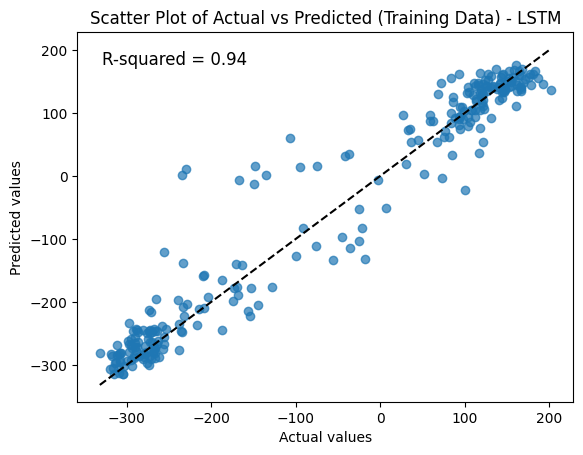

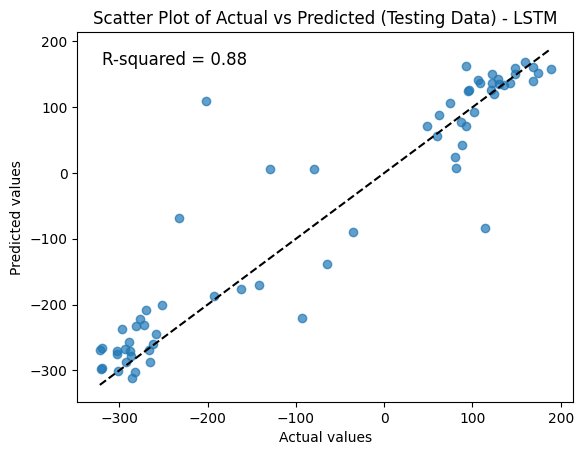

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  4283.915740486989
RMSE:  65.45162901324144
R-squared:  0.8803236379715439
MAE:  45.28318201014049
Log Likelihood:  -139286.99257048545
MAPE:  36.180561365850835
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  1049.4882951163697
RMSE:  32.395806752053105
R-squared:  0.9704954676954931
MAE:  21.472446361302598
Log Likelihood:  -136672.4023837613
MAPE:  23.45464968360251


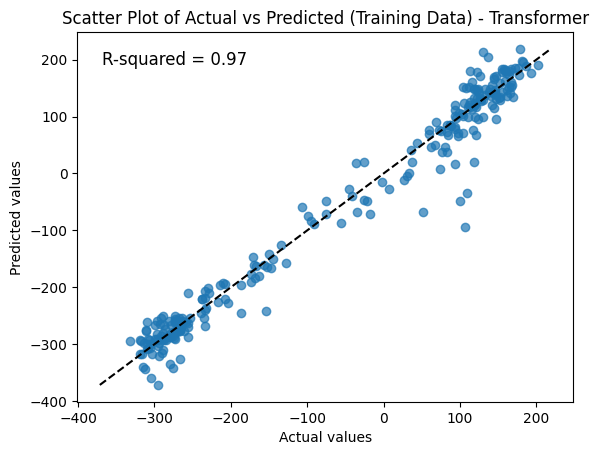

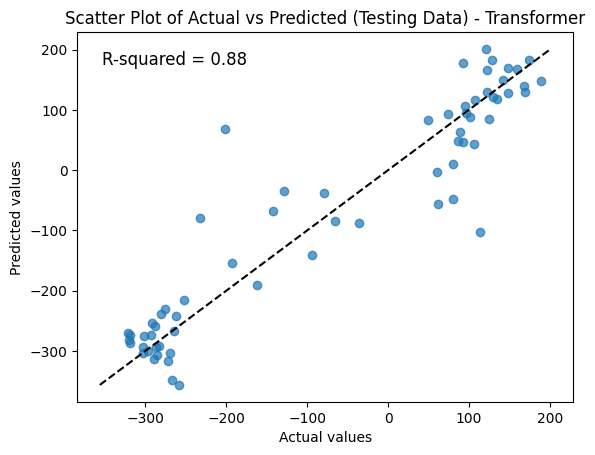

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

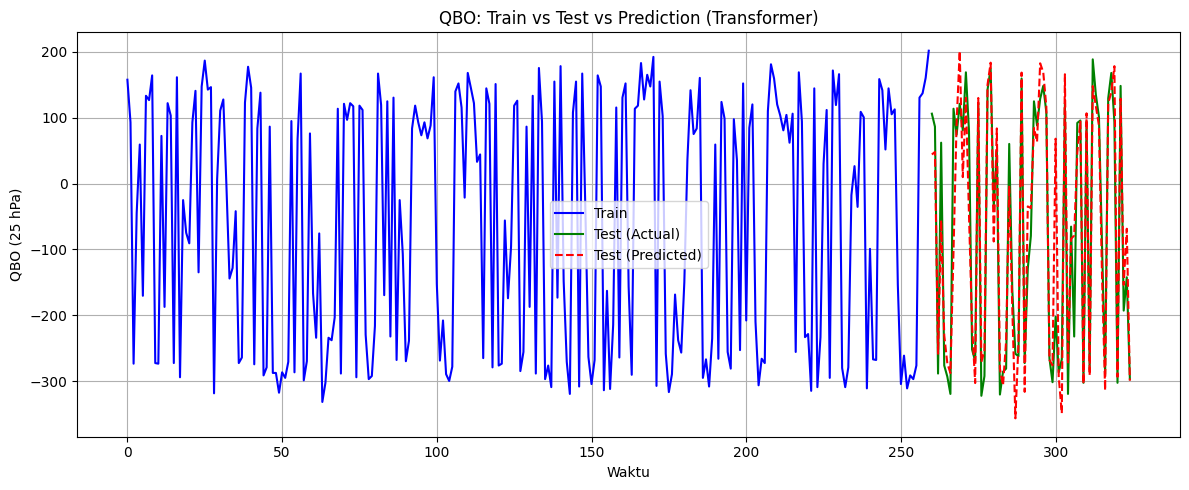

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

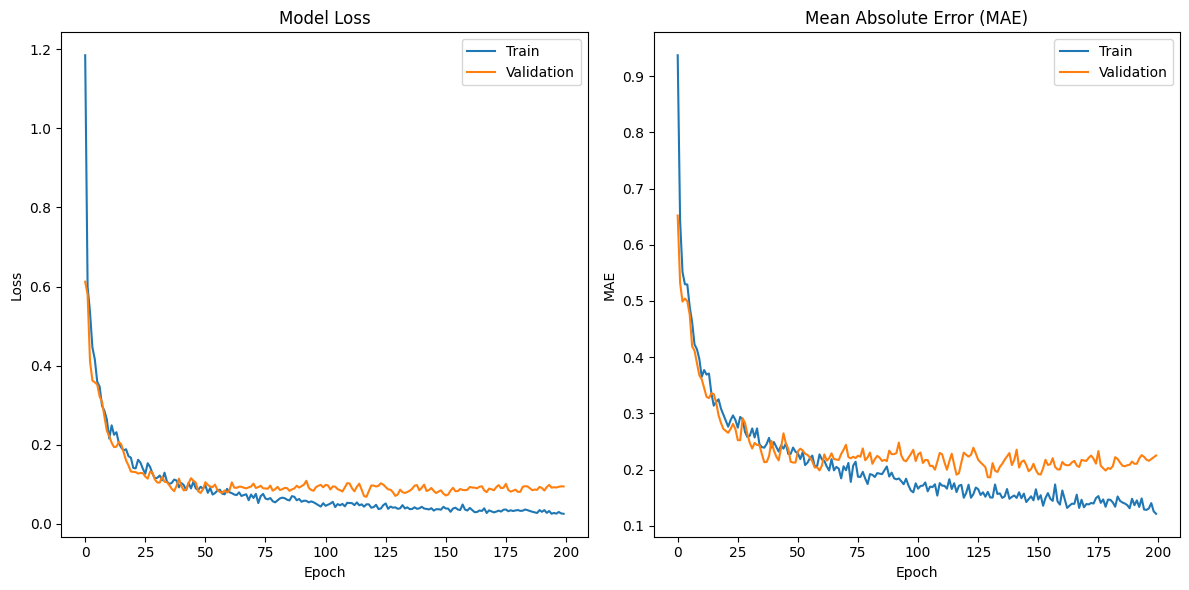

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

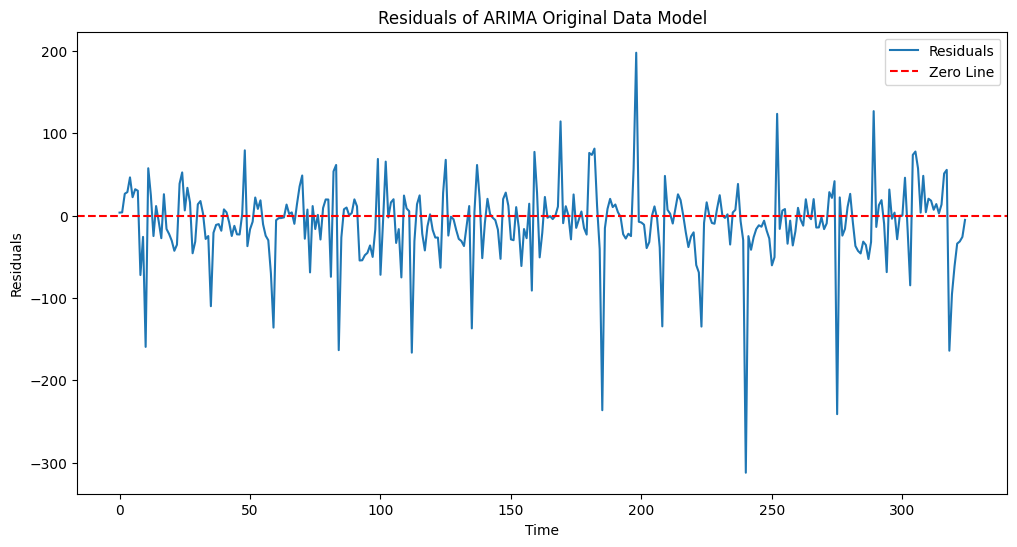

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

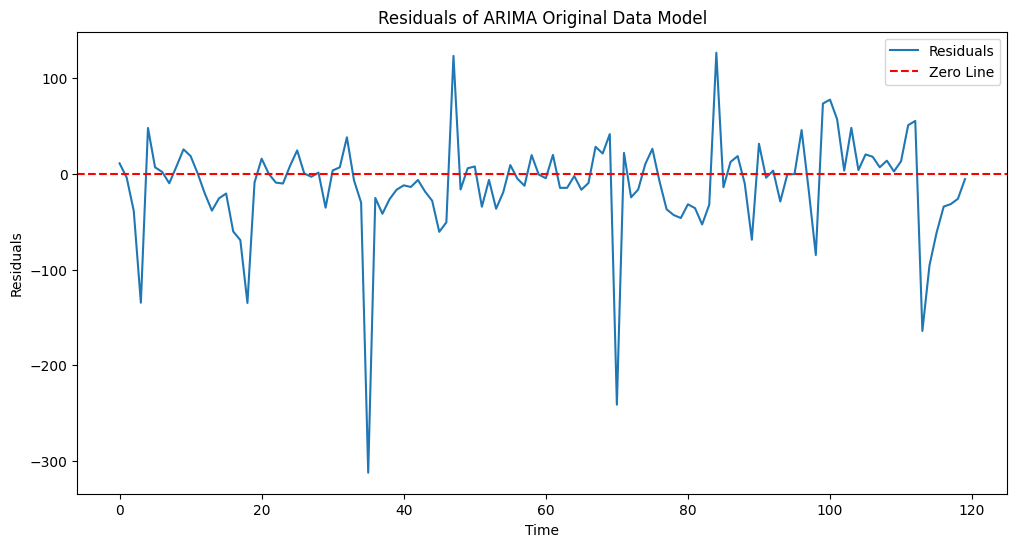

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

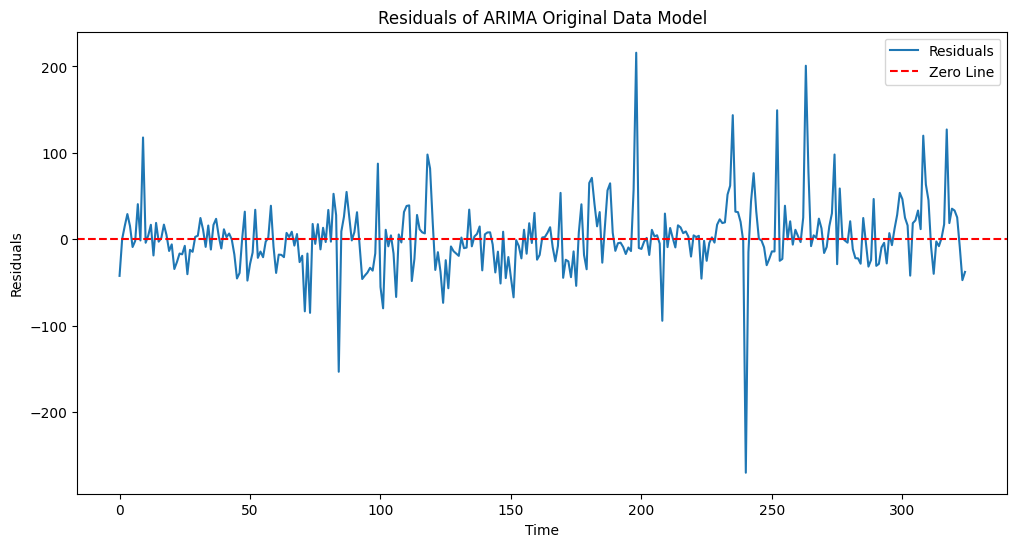

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

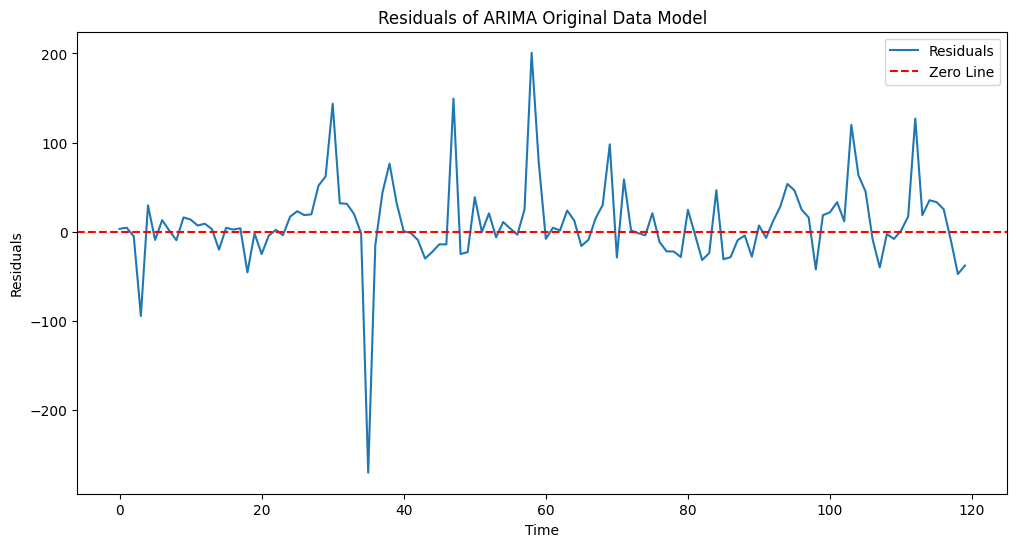

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8578589372659953
P-value: 1.1628073901525544e-16
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

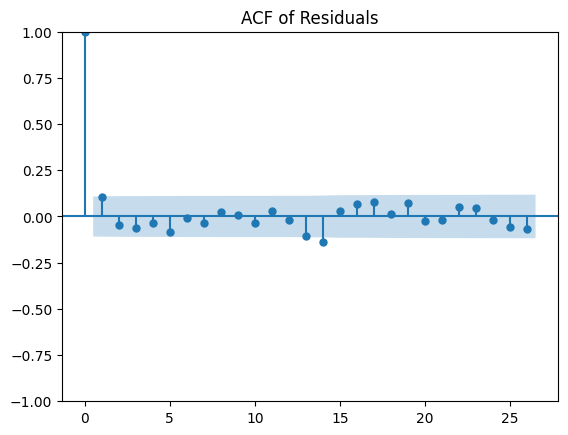

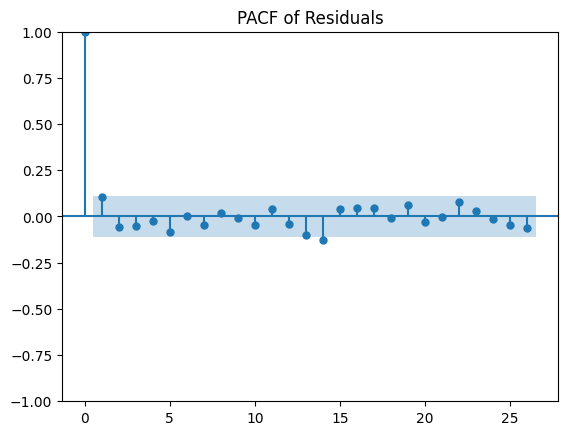

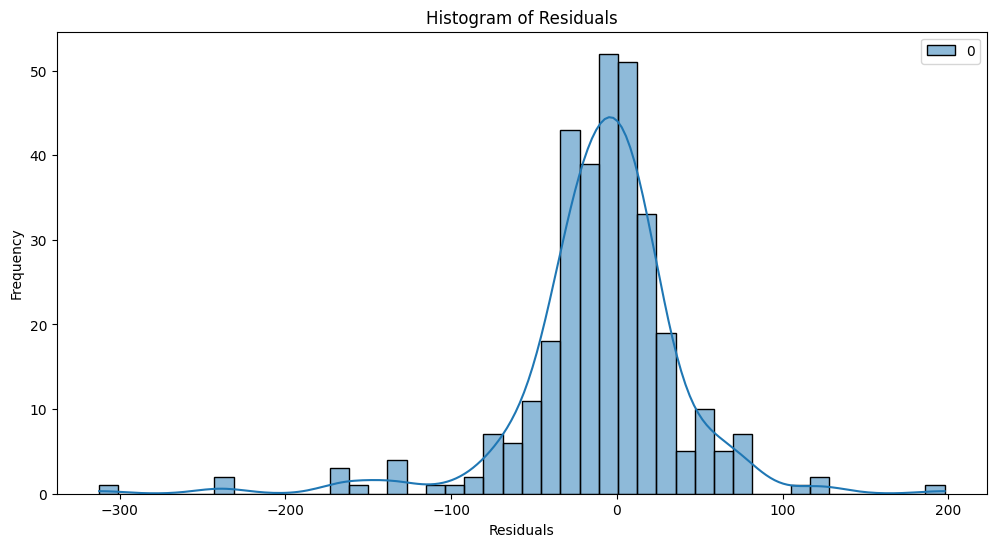

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8050452095585436
P-value: 2.545224858622403e-11
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

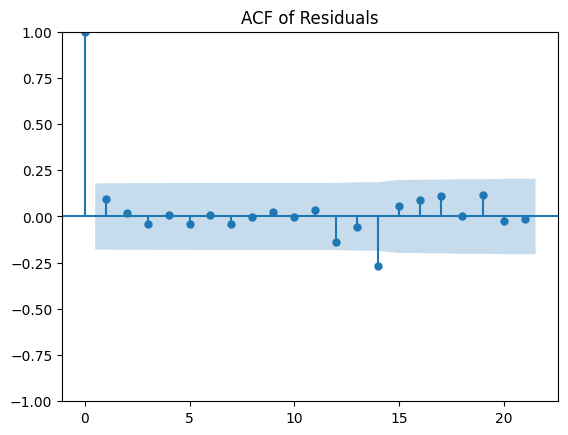

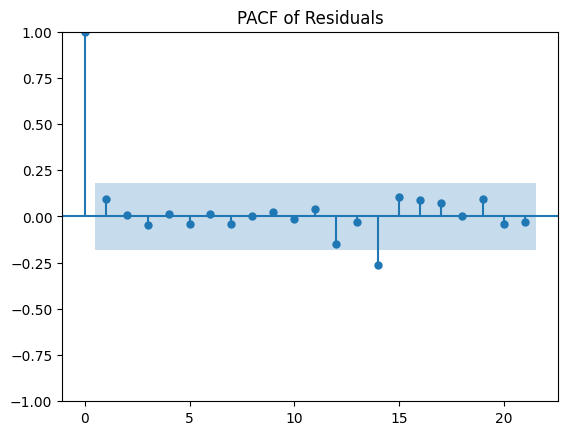

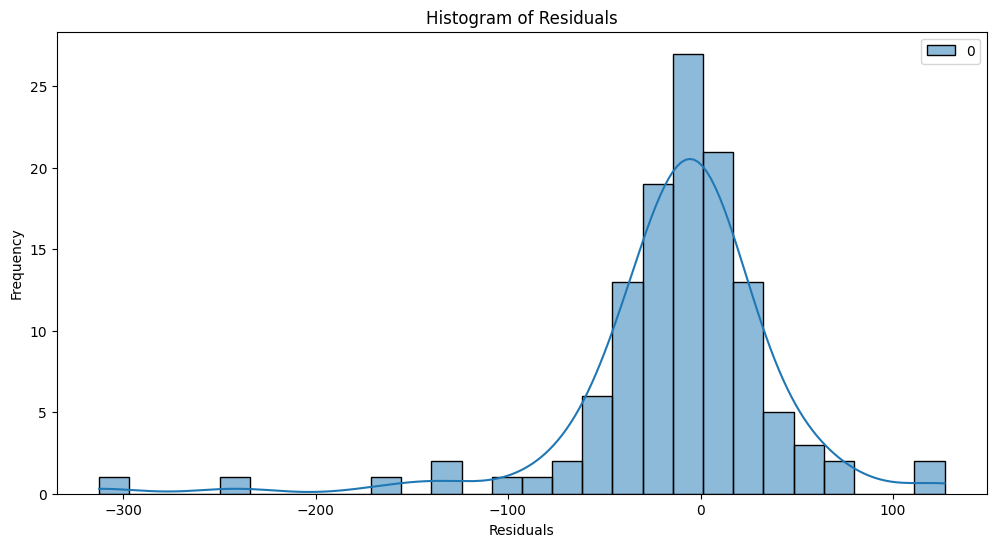

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8599531005381404
P-value: 1.5547399455384106e-16
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

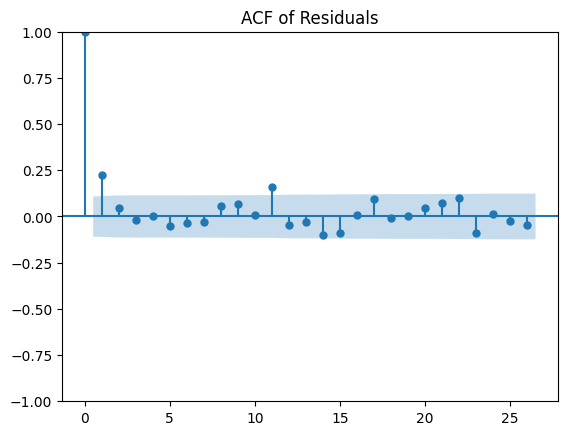

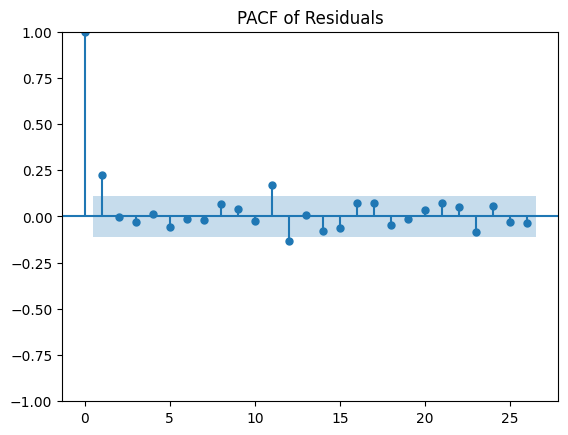

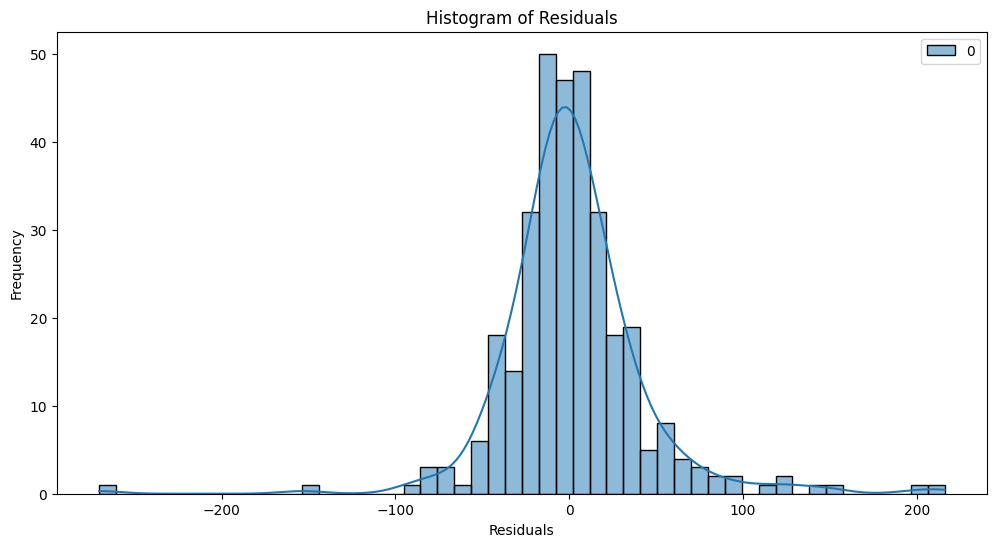

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8033697482586533
P-value: 2.2374009744333702e-11
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

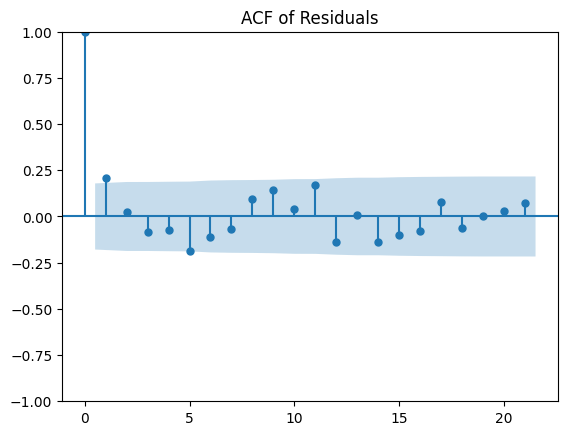

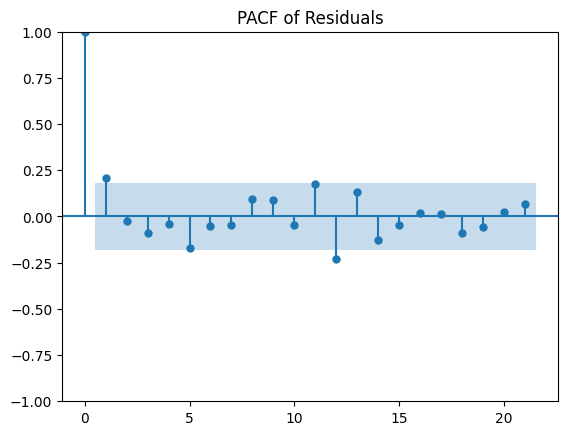

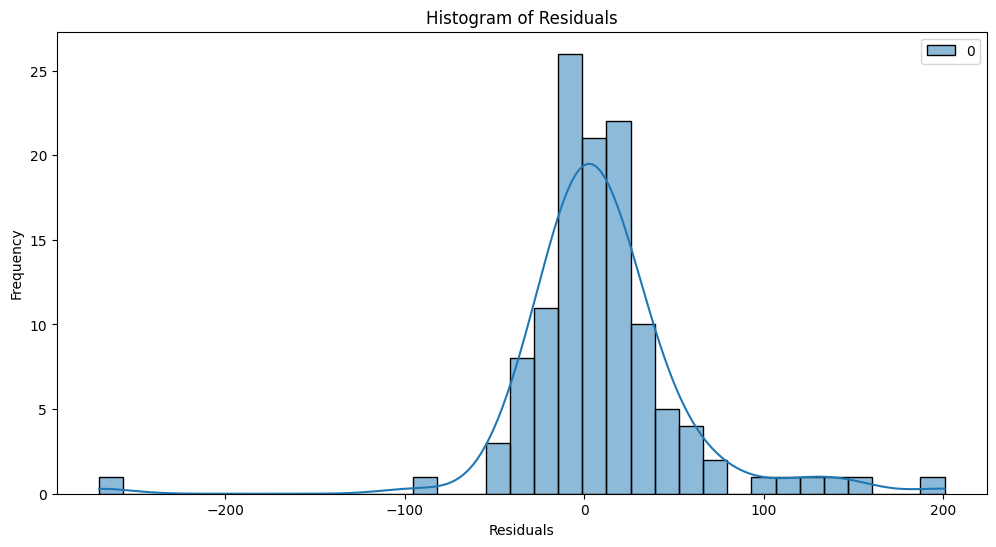

In [49]:
residual_analysis(residuals_final2)

In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dan atur data
data_df = pd.read_excel('QBO Data.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)
data_df = data_df[['25 hPa']]

In [51]:
# Fit ARIMA (bisa ubah order sesuai hasil AIC/BIC terbaik)
model_arima = ARIMA(data_df['25 hPa'], order=(4, 0, 5))  # Contoh order
model_fit = model_arima.fit()

# Prediksi in-sample
arima_pred = model_fit.fittedvalues

# Residual = aktual - prediksi
data_df['residual'] = data_df['25 hPa'] - arima_pred

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

In [52]:
# Gunakan residual sebagai target Transformer
target_col = 'residual'

# Tambahkan fitur seperti sebelumnya (gunakan data_df)
add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

# Drop NaN
data_df = data_df.dropna()

# Pisahkan input dan target
X = data_df.drop(columns=['25 hPa', 'residual'])
y = data_df['residual']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tambahkan dimensi time untuk Transformer
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  # shape: (samples, time, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

In [54]:
def build_transformer(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_transformer(X_train_scaled.shape[1:])  # input shape = (time, features)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 78)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      5,056 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1, 64)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train Transformer on residuals
model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Prediksi residual
residual_pred = model.predict(X_test_scaled).flatten()

# Prediksi ARIMA untuk periode test
arima_forecast = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

# Kombinasi: ARIMA + Transformer
final_pred = arima_forecast + residual_pred

# Evaluasi
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test + arima_forecast, final_pred)))
print("R2 Score:", r2_score(y_test + arima_forecast, final_pred))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2465.6284 - val_loss: 1373.8760
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2157.1392 - val_loss: 1347.4441
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1913.1464 - val_loss: 1319.3571
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2010.9336 - val_loss: 1283.1914
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2282.3982 - val_loss: 1248.0070
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1684.1522 - val_loss: 1199.2386
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2014.7124 - val_loss: 1129.4343
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1871.3654 - val_loss: 1136.9906
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2131.2131 - val_loss: 1031.1969
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2055.1086 - val_loss: 953.8902
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2150.1750 - val_loss: 977.9211

ValueError: operands could not be broadcast together with shapes (76,) (71,) 